# Process Gene Expression from DataDescriptor
This notebook will prepare gene expression information from [Nature Scientific Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903355/pdf/sdata201861.pdf).
The data is already quantified (FPKM) and contains normal and tumor tissue samples from TCGA as well as normal tissue from GTEX.
I will only use the GTEX and TCGA tumor data to compute _log2 fold changes_ of the two.

**The result of this notebook will be a csv file containing the mean fold changes per gene and cancer type and a HDF5 container with the raw fold changes per patient.**

In [1]:
import pandas as pd
import numpy as np
import os, sys, h5py
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
plt.rc('font', family='Times New Roman')
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Paramters
* `GTEX_NORMAL`: Use [GTEx](https://gtexportal.org/home/) normal tissue gene expression or TCGA normal gene expression.
* `USE_PATIENT_NORMAL_IF_AVAILABLE`: Only valid with TCGA normals. Whether to normalize to the median expression of all normals or whether to normalize to the same patient if that data is available.

In [2]:
GTEX_NORMAL = False
USE_PATIENT_NORMAL_IF_AVAILABLE = True

## Step 1: Loading data for tissues and computing log2 fold changes
The data can be loaded from the gzipped files directly. The fold changes can be computed as:
\begin{equation*}
FC_c = \log_2\big(\frac{median(P_c)}{median(N_t)}\big)
\end{equation*}
where $P_c \in \mathbb{R}^{n \times m}$ is the patient-wise matrix containing the FPKM-normalized read counts for $n$ patients (columns) and $m$ genes (rows) for a cancer type $c$. $N_t$ is the gtex normal tissue matrix for a tissue $t$ that corresponds to the cancer type $c$.

For the normal data, we first compute the mean over all samples and then divide that by the FPKM counts for each patient in $P_c$. Only after that, we compute the mean across the patients.

In [3]:
get_patient_from_barcode = lambda x: '-'.join(str(x).split('-')[:3]) # TCGA barcode for patient

def get_a_values(col, normal):
    patients_with_normal = normal.columns.map(get_patient_from_barcode)
    
    if get_patient_from_barcode(col.name) in patients_with_normal:
        idx_col = patients_with_normal == get_patient_from_barcode(col.name)
        corresponding_patient_normal = normal.iloc[:, idx_col]
        average = (col * corresponding_patient_normal.median(axis=1)) #* 0.5
    return average

def normalize_sample(col, normal):
    patients_with_normal = normal.columns.map(get_patient_from_barcode)
    
    if get_patient_from_barcode(col.name) in patients_with_normal:
        idx_col = patients_with_normal == get_patient_from_barcode(col.name)
        corresponding_patient_normal = normal.iloc[:, idx_col]
        fc = col / (corresponding_patient_normal.median(axis=1) + 1)
    else:
        fc = col / (normal.median(axis=1) + 1)
    return fc

# function to get the fold changes
def compute_geneexpression_foldchange(tumor_path, normal_path, use_patients_if_possible=True):
    # read tumor and normal data
    tumor_ge = pd.read_csv(tumor_path, compression='gzip', sep='\t').set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
    normal_ge = pd.read_csv(normal_path, compression='gzip', sep='\t').set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
    assert (np.all(tumor_ge.index == normal_ge.index))

    # compute mean expression for tumor and normal. Then, compute log
    if use_patients_if_possible:
        fc = tumor_ge.apply(lambda col: normalize_sample(col, normal_ge), axis=0).median(axis=1)
    else:
        fc = tumor_ge.median(axis=1) / normal_ge.median(axis=1)
    log_fc = np.log2(fc)
    log_fc = log_fc.replace([np.inf, -np.inf], np.nan).dropna(axis=0) # remove NaN and inf (from division by 0 or 0+eta)
    print ("Dropped {} genes because they contained NaNs".format(fc.shape[0]-log_fc.shape[0]))
    return log_fc, tumor_ge, normal_ge

In [4]:
# get the file names ready
dir_name = '../../data/pancancer/TCGA/expression/tcga_expr_datadescriptor_raw/'
tumor_path = os.path.join(dir_name, '{}-rsem-count-tcga-t.txt.gz')
gtex_path = os.path.join(dir_name, '{}-rsem-count-gtex.txt.gz')
tcga_normal_path = os.path.join(dir_name, '{}-rsem-count-tcga.txt.gz')

# now, apply that function for all TCGA-project and tissue pairs
tissue_pairs = [('bladder', 'blca'), ('breast', 'brca'), ('cervix', 'cesc'),
                ('uterus', 'ucec'), ('colon', 'read'),
                ('colon', 'coad'), ('liver', 'lihc'), ('salivary', 'hnsc'),
                ('esophagus_mus', 'esca'), ('prostate', 'prad'), ('stomach', 'stad'),
                ('thyroid', 'thca'), ('lung', 'luad'), ('lung', 'lusc'),
                ('kidney', 'kirc'), ('kidney', 'kirp')]

log_fold_changes = []
tumor_fpkm = []
gtex_fpkm = []
tcga_normal_fpkm = []
for gtex_tissue, tcga_project in tissue_pairs:
    fc_gtex, tumor, gtex = compute_geneexpression_foldchange(tumor_path=tumor_path.format(tcga_project),
                                                             normal_path=gtex_path.format(gtex_tissue),
                                                             use_patients_if_possible=False)
    
    fc_tcga, tumor, normal = compute_geneexpression_foldchange(tumor_path=tumor_path.format(tcga_project),
                                                               normal_path=tcga_normal_path.format(tcga_project))
    if GTEX_NORMAL:
        log_fold_changes.append(fc_gtex)
    else:
        log_fold_changes.append(fc_tcga)
    tumor_fpkm.append(tumor)
    gtex_fpkm.append(gtex)
    tcga_normal_fpkm.append(normal)

# convert everything to one big DataFrame
all_foldchanges = pd.DataFrame(log_fold_changes, index=[i[1] for i in tissue_pairs]).T

# drop genes with more than 50% NaNs
#no_genes_withna = all_foldchanges.shape[0]
#all_foldchanges.dropna(axis=0, thresh=all_foldchanges.shape[1] / 2, inplace=True)
#print ("Dropped {} genes because they contained more than 50% NaNs ({} genes left)".format(no_genes_withna - all_foldchanges.shape[0], all_foldchanges.shape[0]))

no_of_nan_elems = all_foldchanges.isnull().sum().sum()
all_foldchanges.replace(np.nan, 0, inplace=True)
print ("Replaced {} NaN values in gene expression with 0 (out of {})".format(no_of_nan_elems, np.prod(all_foldchanges.shape)))
all_foldchanges.head()

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log2


Dropped 3348 genes because they contained NaNs
Dropped 2920 genes because they contained NaNs
Dropped 3092 genes because they contained NaNs
Dropped 2707 genes because they contained NaNs
Dropped 3351 genes because they contained NaNs
Dropped 2868 genes because they contained NaNs
Dropped 3337 genes because they contained NaNs
Dropped 2675 genes because they contained NaNs
Dropped 3251 genes because they contained NaNs
Dropped 2852 genes because they contained NaNs
Dropped 3310 genes because they contained NaNs
Dropped 2965 genes because they contained NaNs
Dropped 3770 genes because they contained NaNs
Dropped 3380 genes because they contained NaNs
Dropped 3189 genes because they contained NaNs
Dropped 2761 genes because they contained NaNs
Dropped 3275 genes because they contained NaNs
Dropped 2242 genes because they contained NaNs
Dropped 2908 genes because they contained NaNs
Dropped 2682 genes because they contained NaNs
Dropped 3055 genes because they contained NaNs
Dropped 2353 

blca      brca      cesc      ucec      read      coad      lihc  \
A1BG     0.226633  1.184298 -2.206794 -0.857162 -1.207777 -1.338266 -1.185094   
A1CF    -1.000000 -1.584963  0.000000 -1.000000 -0.668056 -1.295782 -0.462547   
A2M     -2.414270 -1.316157 -3.960867 -1.926294 -0.990964 -1.457258 -0.895757   
A2ML1    2.971180 -1.115477  6.266787  1.450661 -1.000000  0.000000  0.000000   
A3GALT2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             hnsc      esca      prad      stad      thca      luad      lusc  \
A1BG     1.144881  0.840186 -1.732335 -0.514533  0.914754  0.619915 -0.200561   
A1CF     0.000000 -2.678072  0.000000  2.718366  0.000000 -1.000000  0.000000   
A2M      0.273526  0.243404 -0.125804  0.578988  0.290783 -1.764107 -4.243002   
A2ML1   -2.782339  4.123382 -1.119299 -0.485427 -3.000000  0.415037  7.330917   
A3GALT2  0.000000  0.000000  0.000000 -0.415037  0.000000  0.000000  0.000000   

             kirc      kirp  
A1BG     0.382328 -0.081843  
A1CF     0.271087 -4.192567  
A2M      0.250109 -1.669579  
A2ML1   -1.000000 -2.000000  
A3GALT2  0.000000  0.000000

## Step 2: Reproduce plots from paper to verify correctness
This is the plot from the paper, which I want to reproduce.
![IGF2 and TP53](datadescriptor_plot_igf2_tp53.png)

In [5]:
# dataframes for tcga normal, tumor and gtex
tumor_expr = pd.DataFrame([i.median(axis=1) for i in tumor_fpkm], index=[i[1] for i in tissue_pairs]).T
gtex_expr = pd.DataFrame([i.median(axis=1) for i in gtex_fpkm], index=[i[1] for i in tissue_pairs]).T
normal_expr = pd.DataFrame([i.median(axis=1) for i in tcga_normal_fpkm], index=[i[1] for i in tissue_pairs]).T

# make it a nice format for barplots in seaborn
tumor_expr['Type'] = 'Tumor'
normal_expr['Type'] = 'Normal (TCGA)'
gtex_expr['Type'] = 'Normal (GTEx)'
all_expr = pd.concat((tumor_expr, normal_expr, gtex_expr), axis=0)
all_expr['Name'] = all_expr.index
all_expr_long = pd.melt(all_expr, id_vars=['Type', 'Name'])

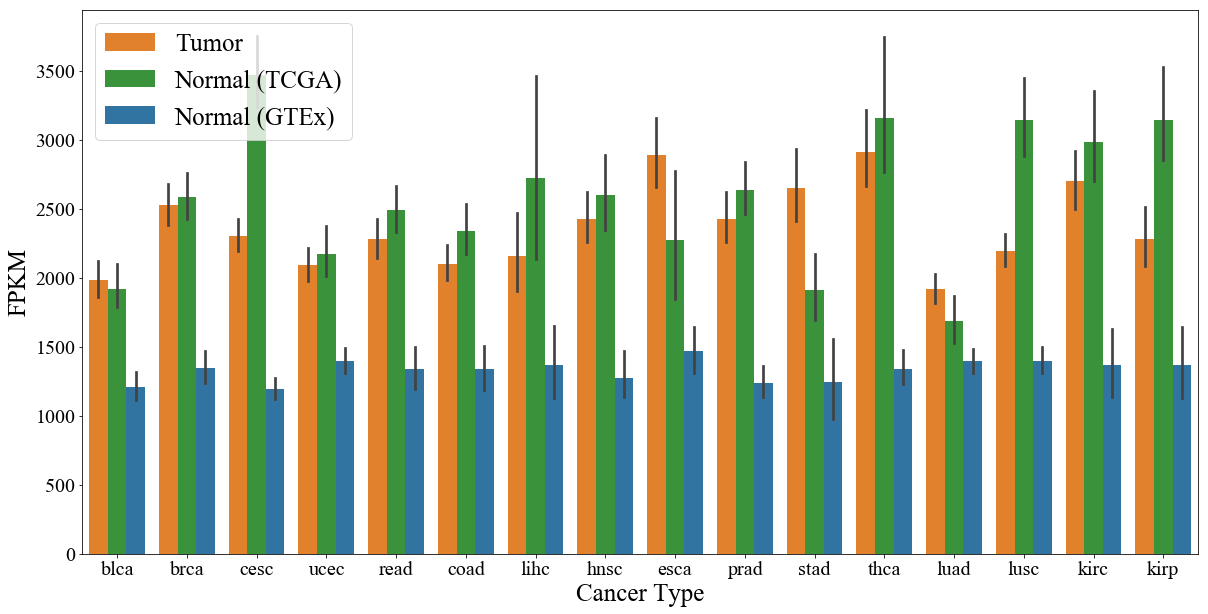

In [6]:
fig = plt.figure(figsize=(20, 10))
gene_name = None
data = all_expr_long[all_expr_long.Name == gene_name] if not gene_name is None else all_expr_long
g = sns.barplot(data=data, x='variable', y='value', hue='Type',
            hue_order=['Tumor', 'Normal (TCGA)', 'Normal (GTEx)'],
            palette={'Tumor': 'C1', 'Normal (TCGA)': 'C2', 'Normal (GTEx)': 'C0'})
g.tick_params(labelsize=20)
g.set_xlabel('Cancer Type', fontsize=25)
g.set_ylabel('FPKM', fontsize=25)
#g.set_yscale('log')
plt.title(gene_name, fontsize=30)
plt.legend(prop={'size': 25})

## Step 3: MA-plots for visualization of correct normalization

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log2
/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log2


Finished MA-plot for blca
Finished MA-plot for brca
Finished MA-plot for cesc
Finished MA-plot for ucec
Finished MA-plot for read
Finished MA-plot for coad
Finished MA-plot for lihc
Finished MA-plot for hnsc
Finished MA-plot for esca
Finished MA-plot for prad
Finished MA-plot for stad
Finished MA-plot for thca
Finished MA-plot for luad
Finished MA-plot for lusc
Finished MA-plot for kirc
Finished MA-plot for kirp


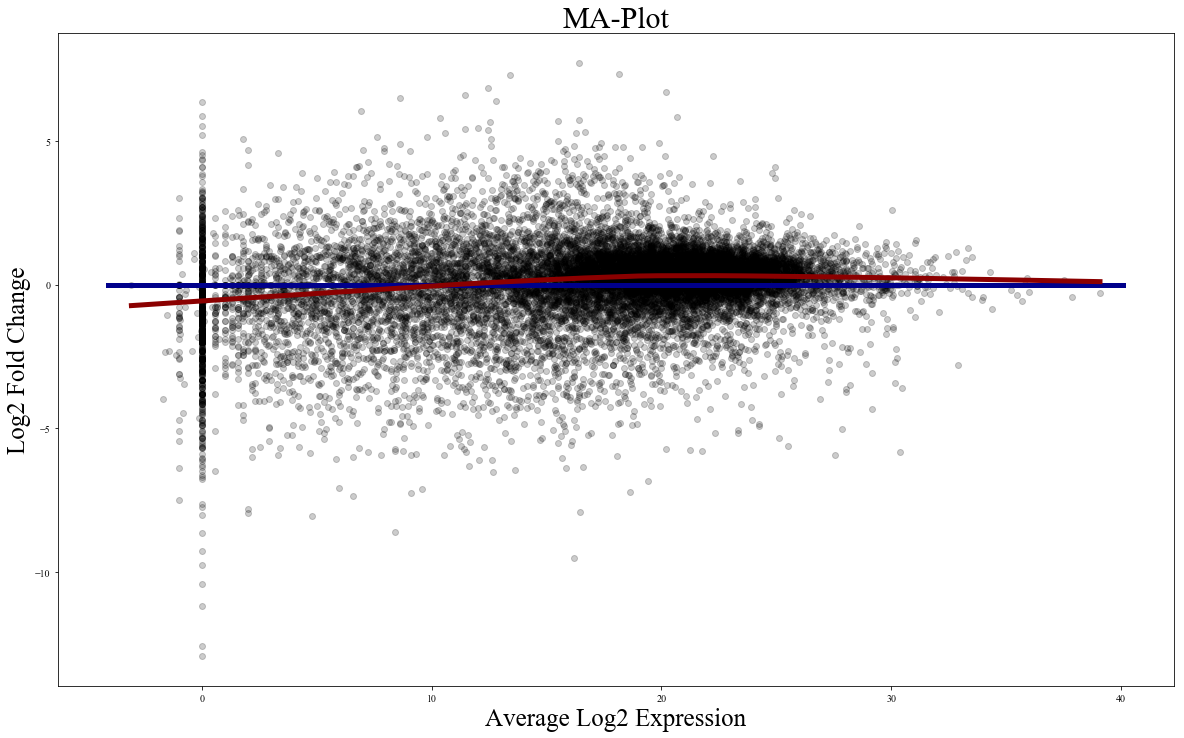

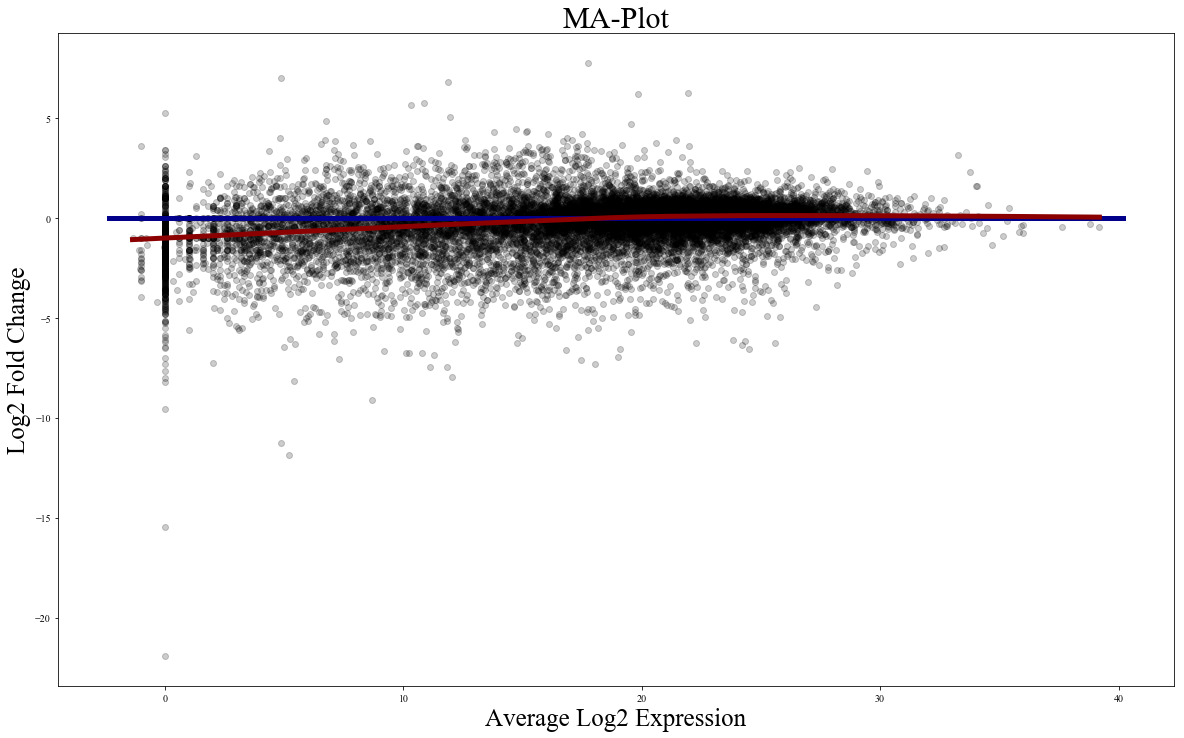

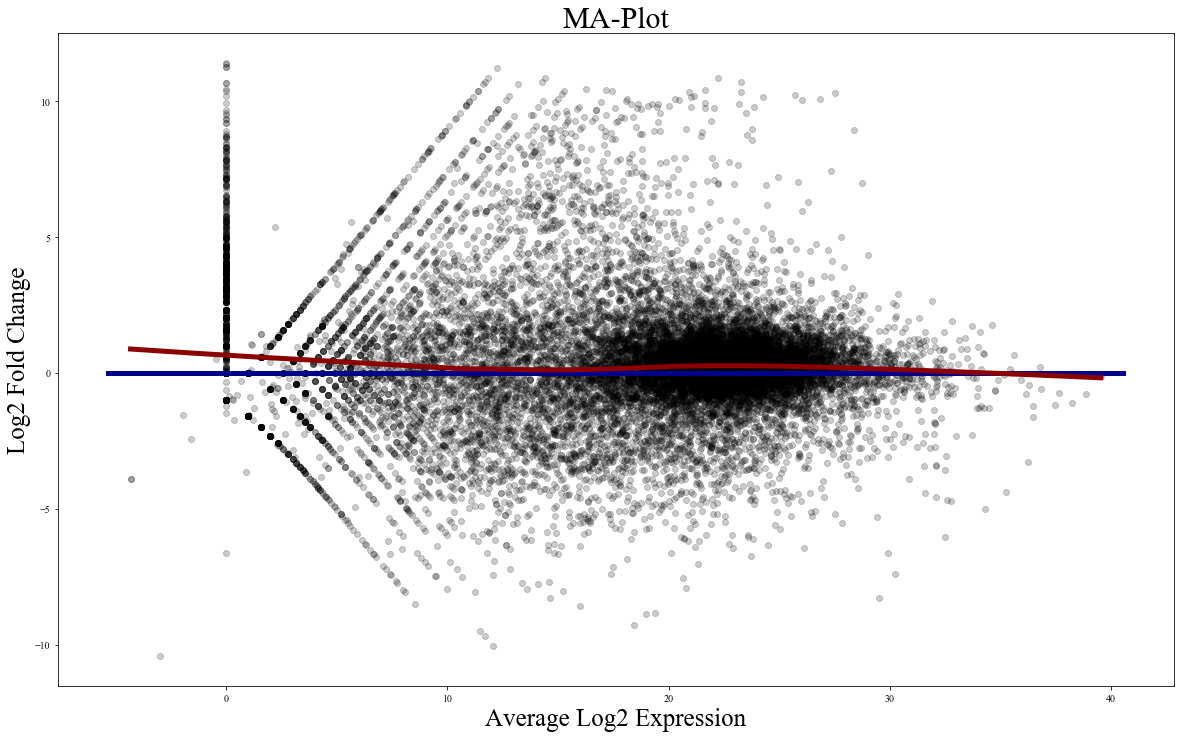

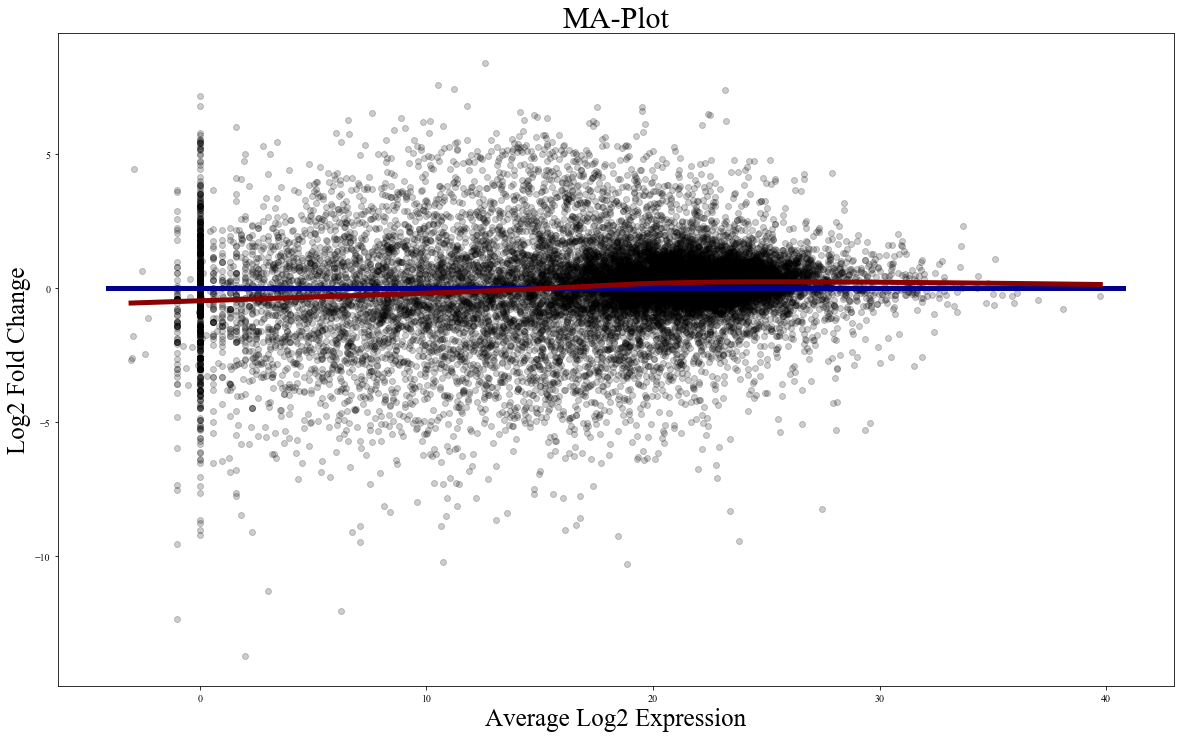

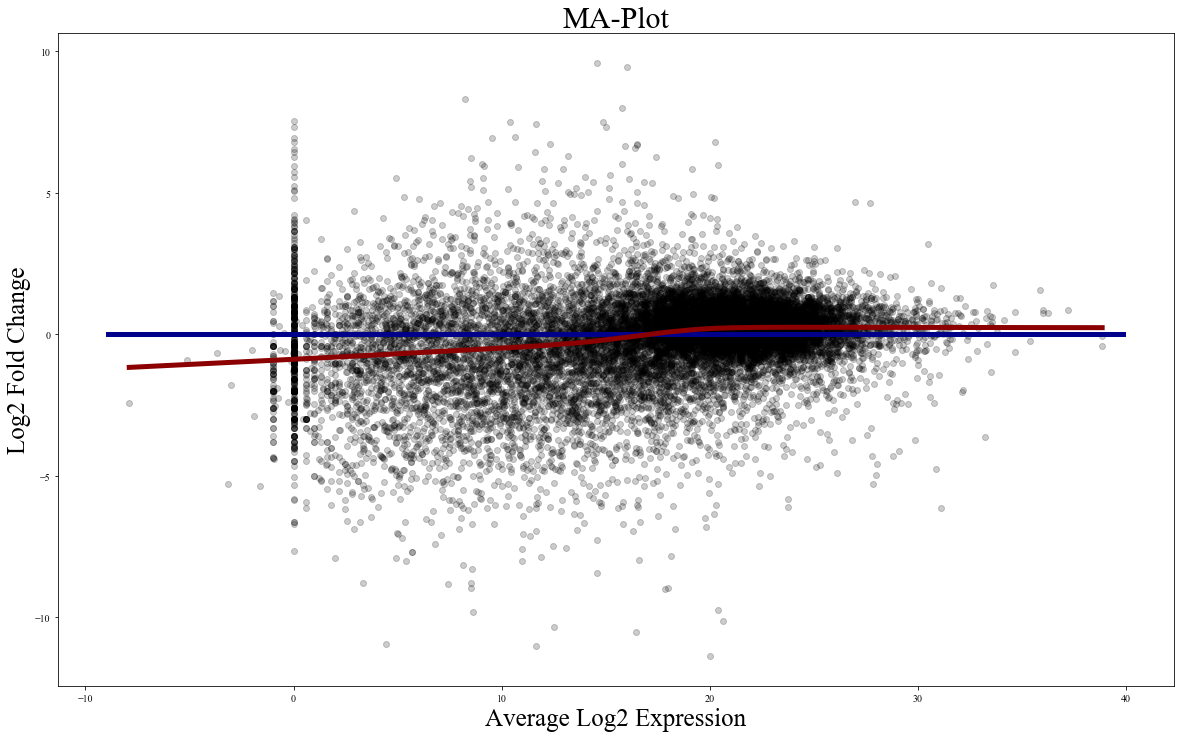

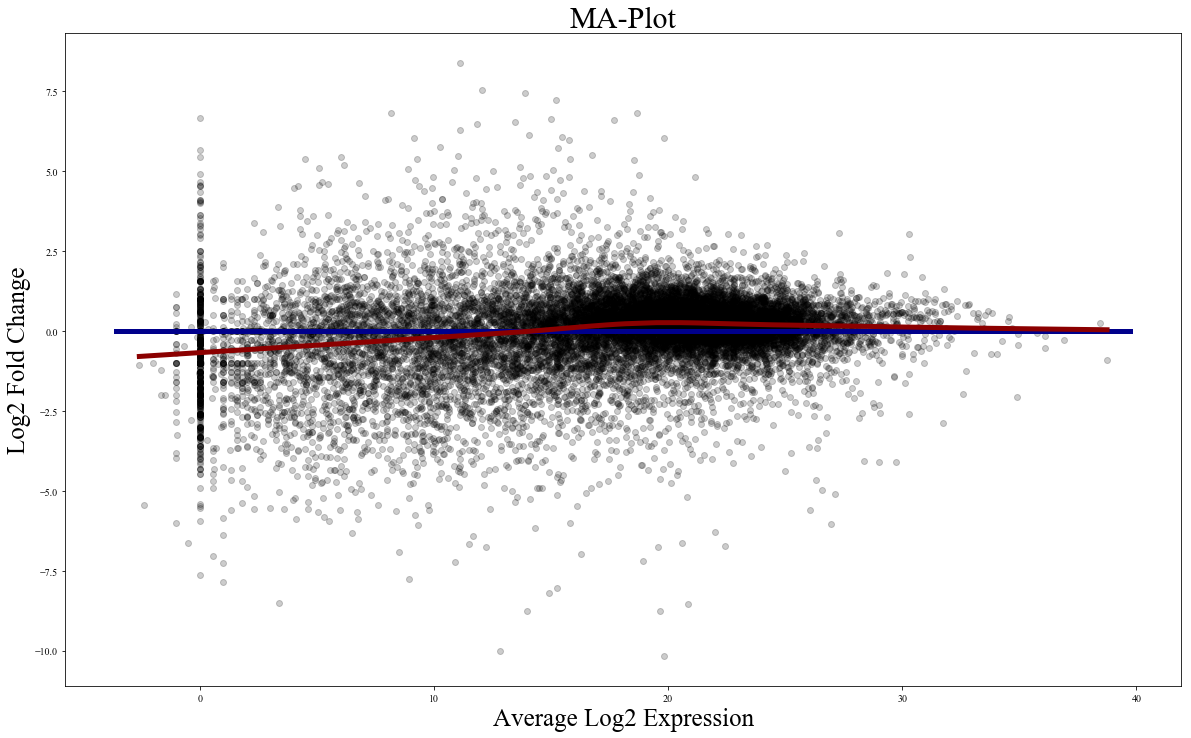

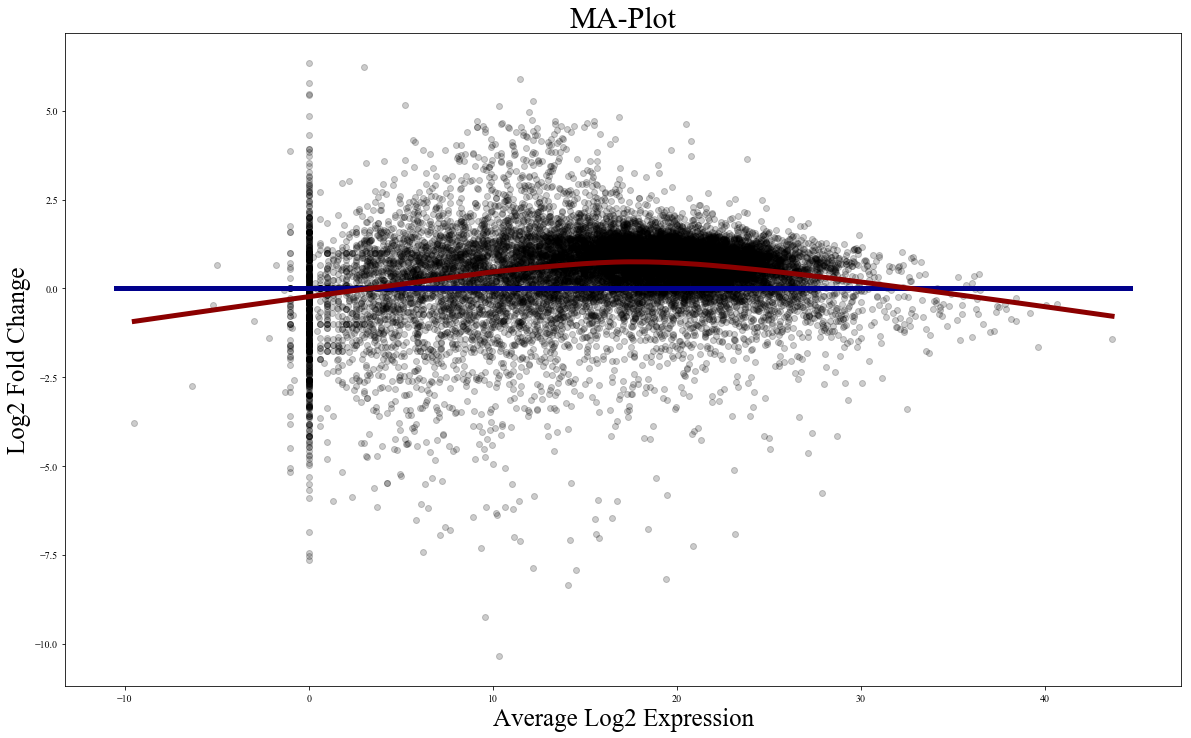

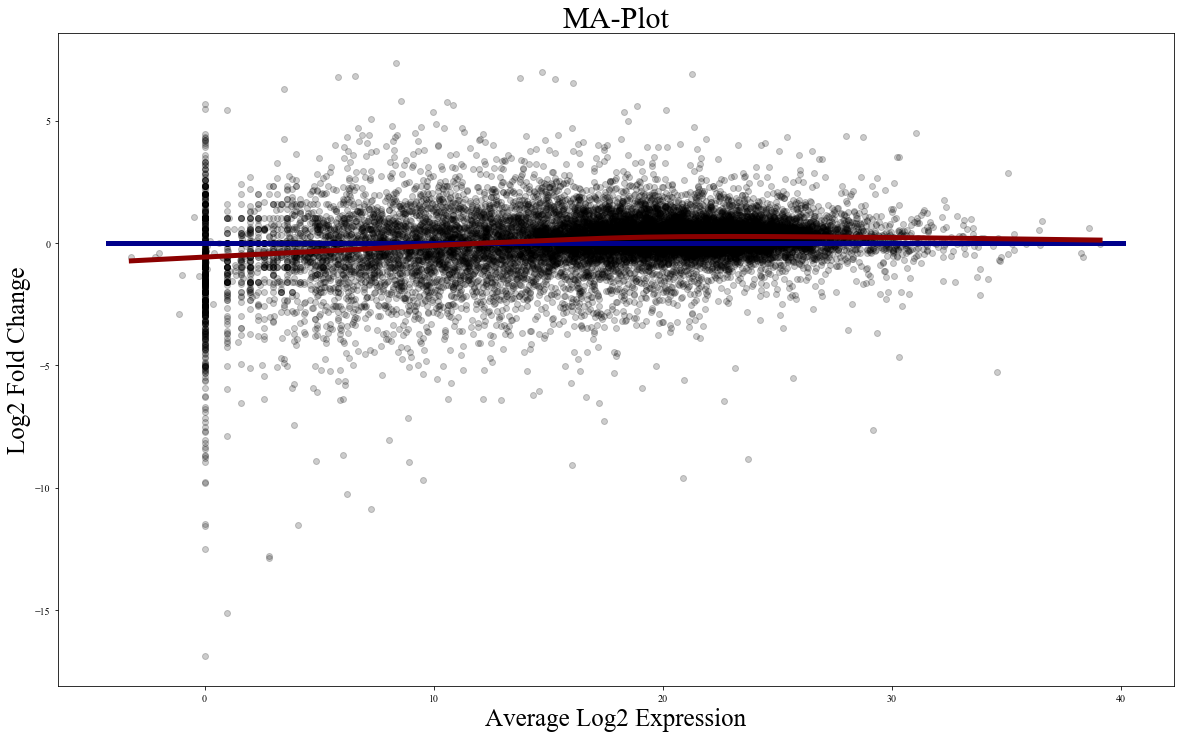

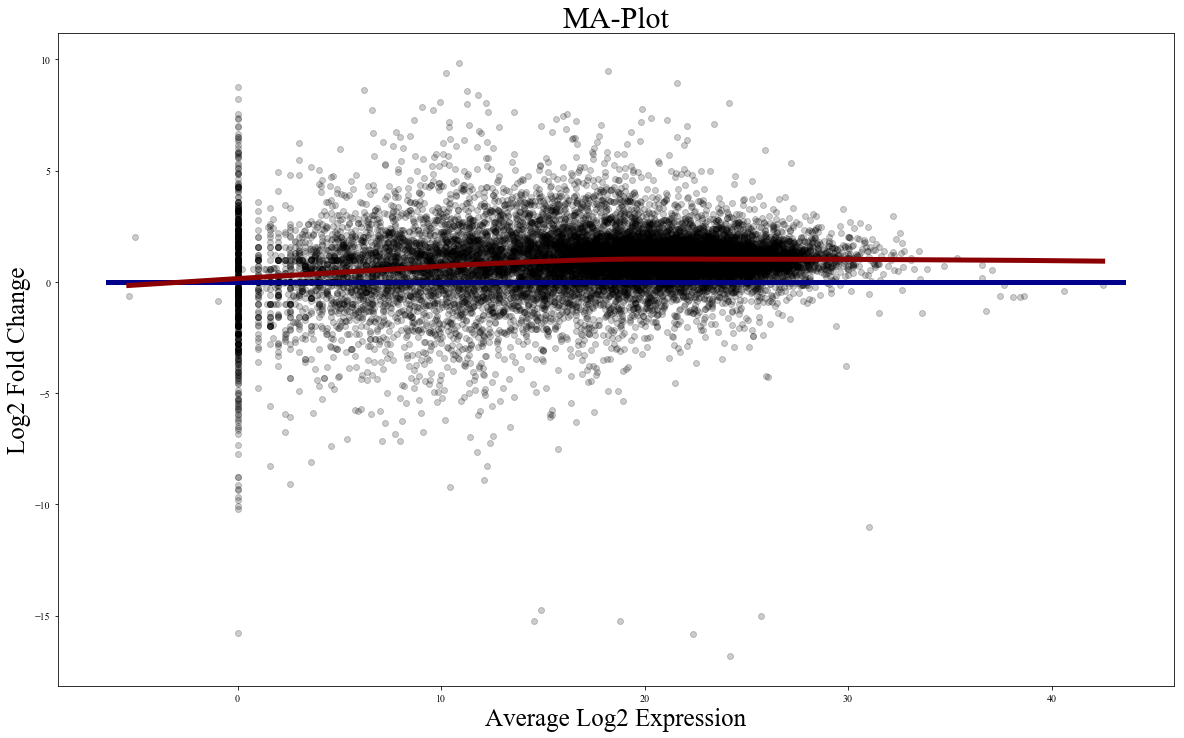

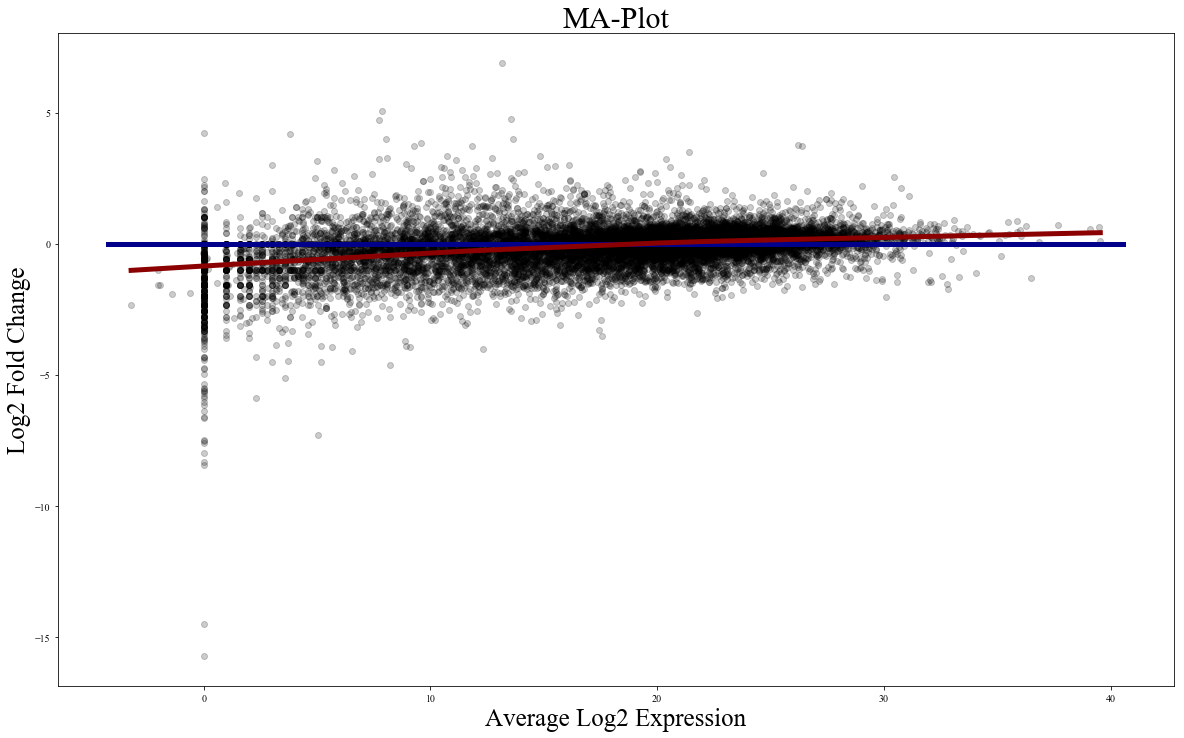

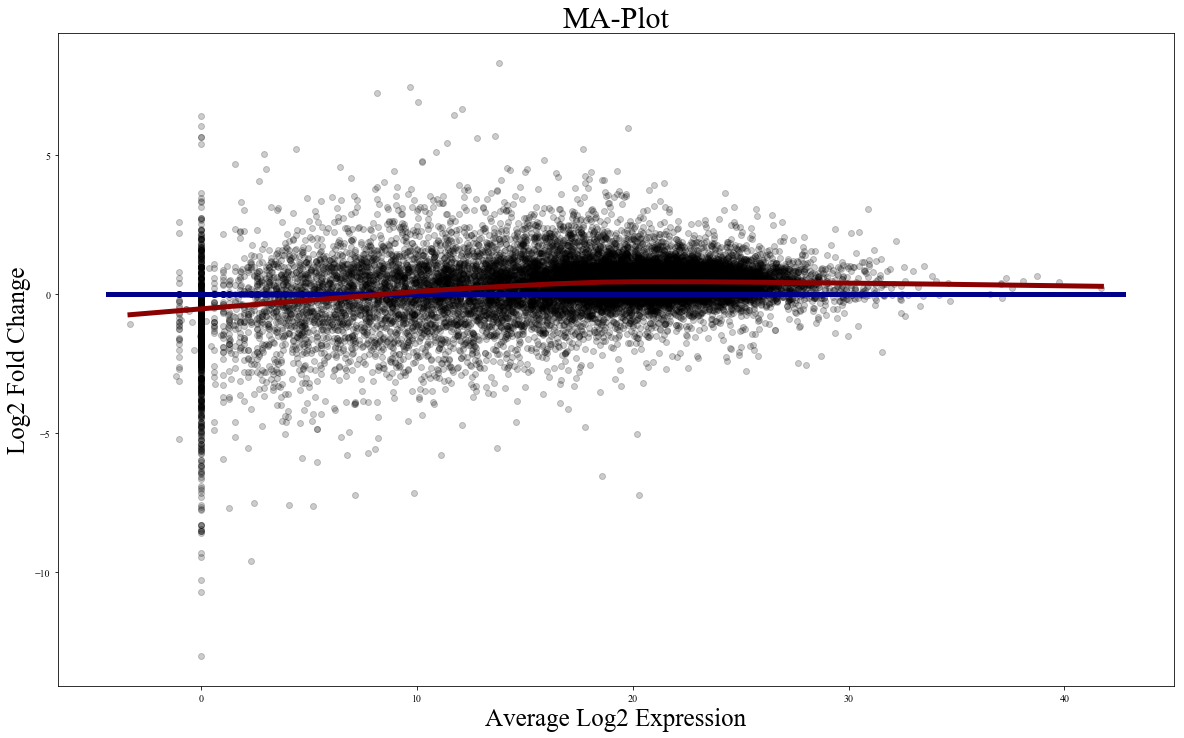

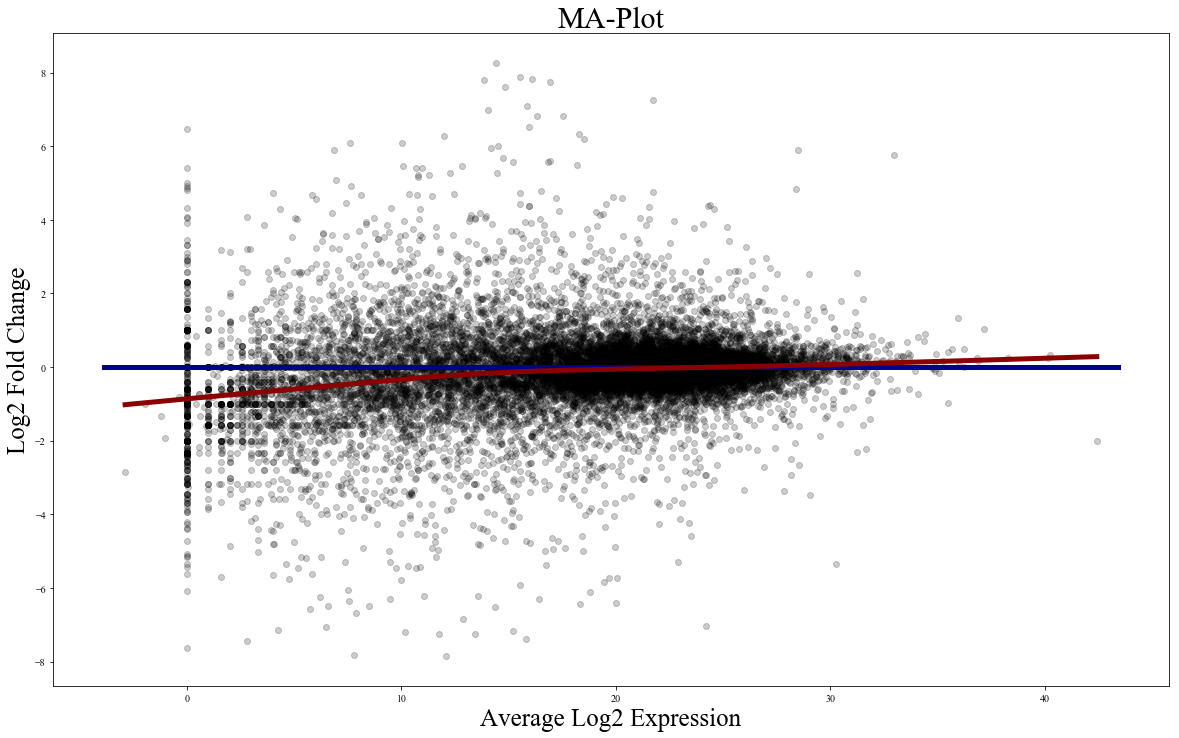

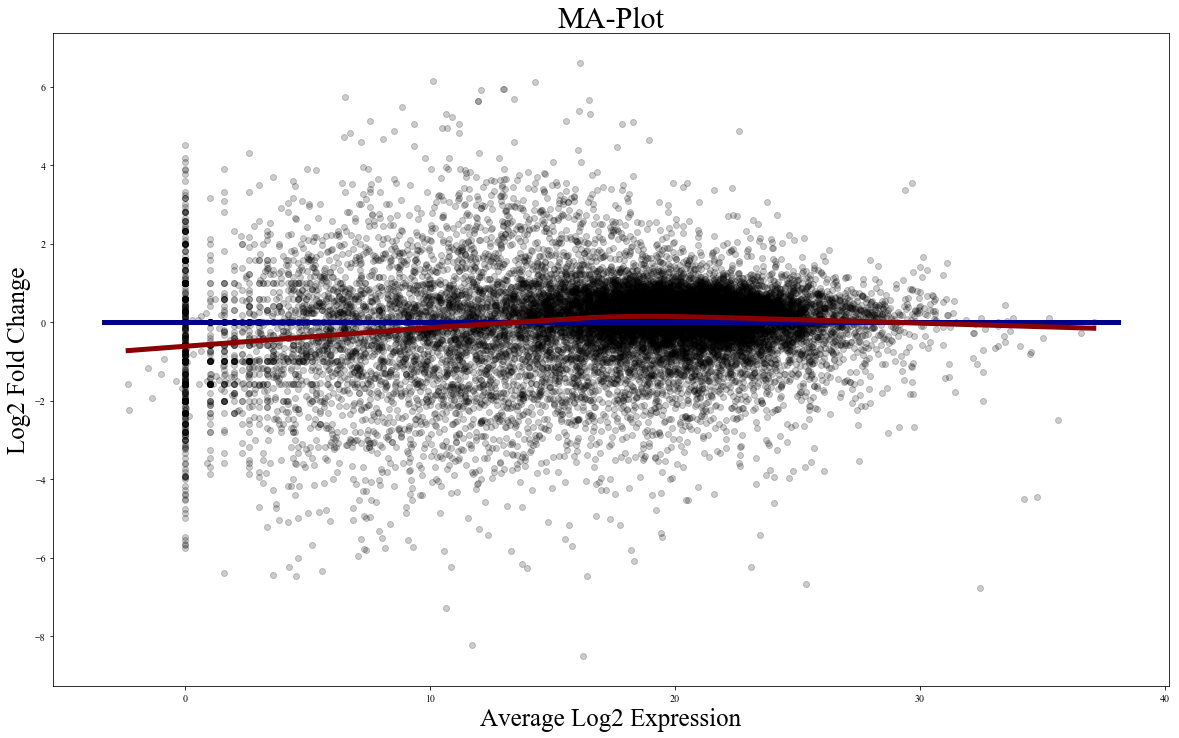

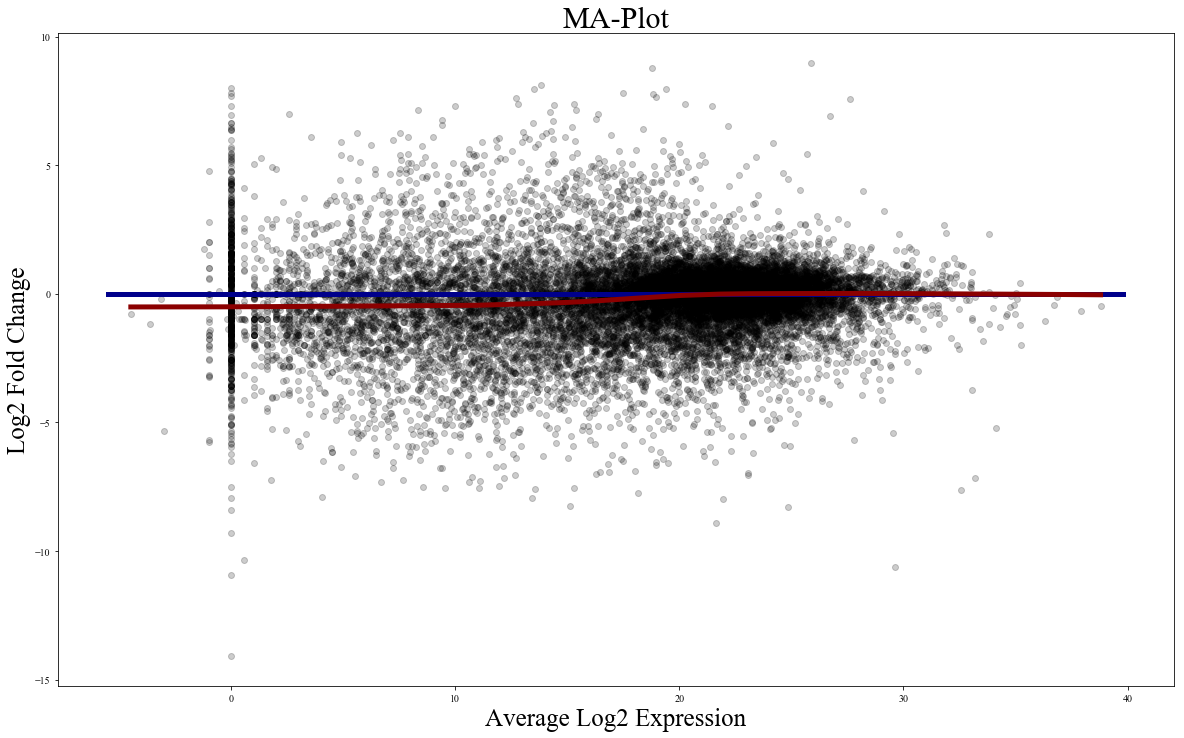

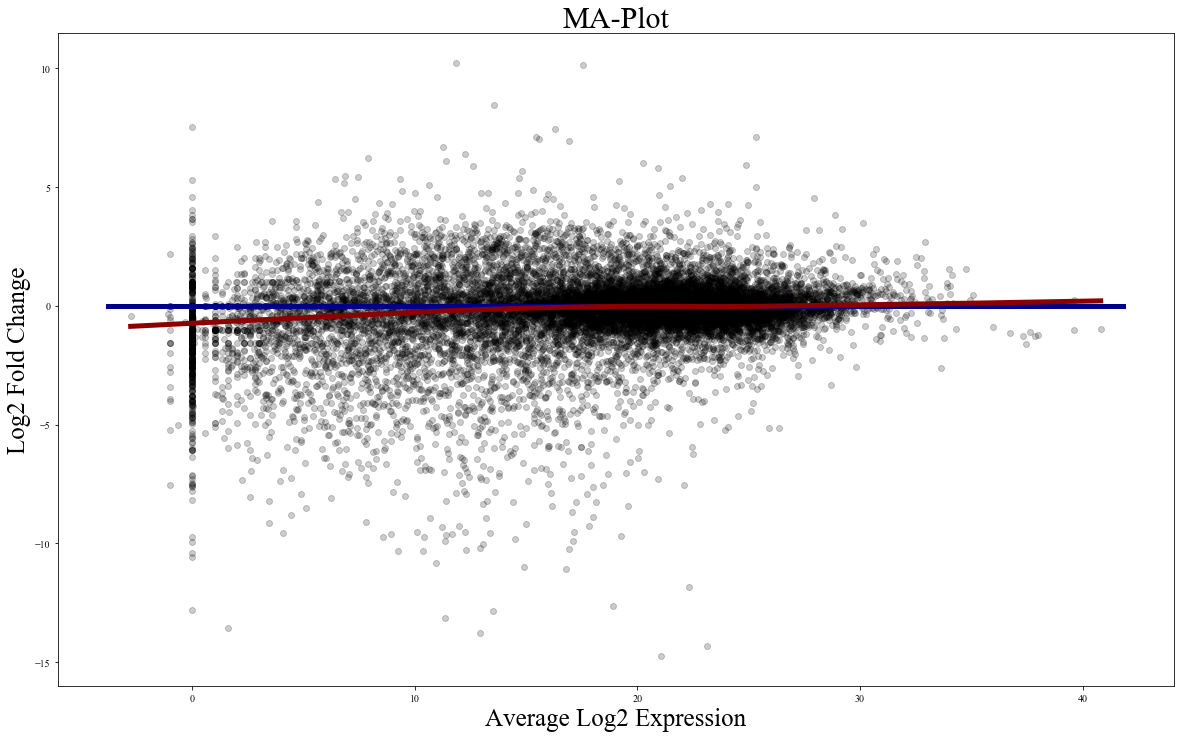

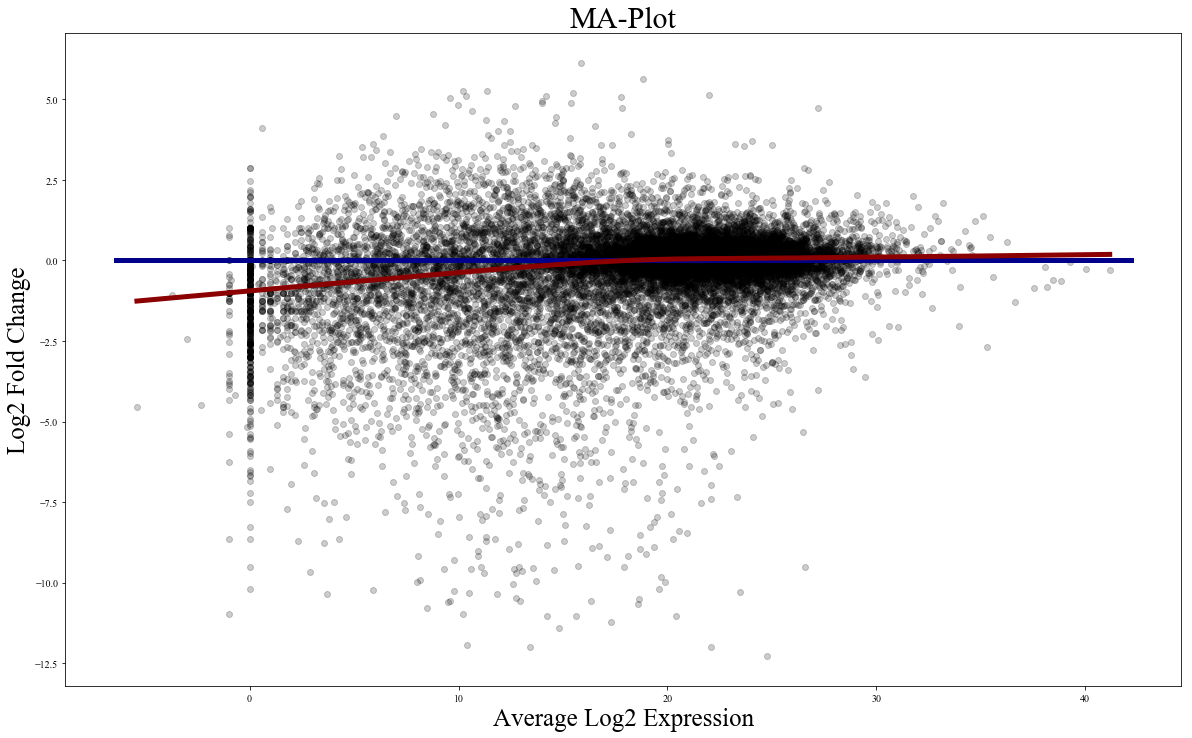

In [94]:
def ma_plot(A, M, output):
    fig = plt.figure(figsize=(20, 12))
    plt.plot([A.min()-1, A.max()+1], [0, 0], lw=5, color='darkblue')
    g = sns.regplot(x=A, y=M, fit_reg=True, ci=None,
                    color='black',
                    scatter_kws={'alpha': 0.2},
                    lowess=True, line_kws={'lw': 5, 'color': 'darkred'}
                   )
    g.set_xlabel('Average Log2 Expression', fontsize=25)
    g.set_ylabel('Log2 Fold Change', fontsize=25)
    g.set_title('MA-Plot', fontsize=30)
    fig.savefig(output, dpi=300)


for i in range(len(log_fold_changes)):
    tissue_name = tissue_pairs[i]
    tumor_ge = tumor_fpkm[i]
    normal_ge = tcga_normal_fpkm[i]
    # compute fold changes between same patient cancer vs. normal
    samples_to_use = [i for i in tumor_ge.columns if get_patient_from_barcode(i) in normal_ge.columns.map(get_patient_from_barcode)]
    fc_patients = tumor_ge[samples_to_use].apply(lambda col: normalize_sample(col, normal_ge))
    assert ((fc_patients.columns == samples_to_use).all())

    # compute M/A values
    M = np.log2(fc_patients.median(axis=1))
    A = np.log2(tumor_ge[samples_to_use].apply(lambda col: get_a_values(col, normal_ge)).median(axis=1)).replace([-np.inf, np.inf], 0)
    
    # plot MA-plot
    ma_plot(M=M, A=A, output='../../data/pancancer/TCGA/expression/ma_plot_tumor_vs_tcga_countnorm_{}.png'.format(tissue_name[1]))
    print ("Finished MA-plot for {}".format(tissue_name[1]))

## Step 4: PCA of Gene $\times$ Sample Matrix

In [7]:
tumor_samples_pca = []
for i in range(len(tumor_fpkm)):
    tumor_ctype = tumor_fpkm[i].T
    tumor_ctype['Tissue'] = tissue_pairs[i][1].upper()
    tumor_ctype['Type'] = 'Tumor'
    tumor_samples_pca.append(tumor_ctype)

normal_samples_pca = []
for i in range(len(tumor_fpkm)):
    normal_ctype = tcga_normal_fpkm[i].T
    normal_ctype['Tissue'] = tissue_pairs[i][1].upper()
    normal_ctype['Type'] = 'Normal_TCGA'
    normal_samples_pca.append(normal_ctype)

gtex_samples_pca = []
for i in range(len(tumor_fpkm)):
    gtex_ctype = gtex_fpkm[i].T
    gtex_ctype['Tissue'] = tissue_pairs[i][1].upper()
    gtex_ctype['Type'] = 'Normal_GTEx'
    gtex_samples_pca.append(gtex_ctype)

all_tumor_samples = pd.concat(tumor_samples_pca, axis=0)
all_tcganormal_samples = pd.concat(normal_samples_pca, axis=0)
all_gtexnormal_samples = pd.concat(gtex_samples_pca, axis=0)

In [8]:
pca_input = pd.concat((all_tumor_samples, all_tcganormal_samples, all_gtexnormal_samples), axis=0).dropna(axis=1)
pca_input.shape

(9365, 20244)

In [9]:
print (all_tumor_samples.shape, all_gtexnormal_samples.shape, all_tcganormal_samples.shape)

#emb = TSNE(n_components=2).fit_transform(pca_input.drop(['Type', 'Tissue'], axis=1))
reducer = umap.UMAP()
emb = reducer.fit_transform(pca_input.drop(['Type', 'Tissue'], axis=1))

(6004, 20244) (2712, 20244) (649, 20244)


Text(0.5, 1.0, 'UMAP Embedding (Tumor, Normal, GTEx) for RSEM read counts (no normalization)')

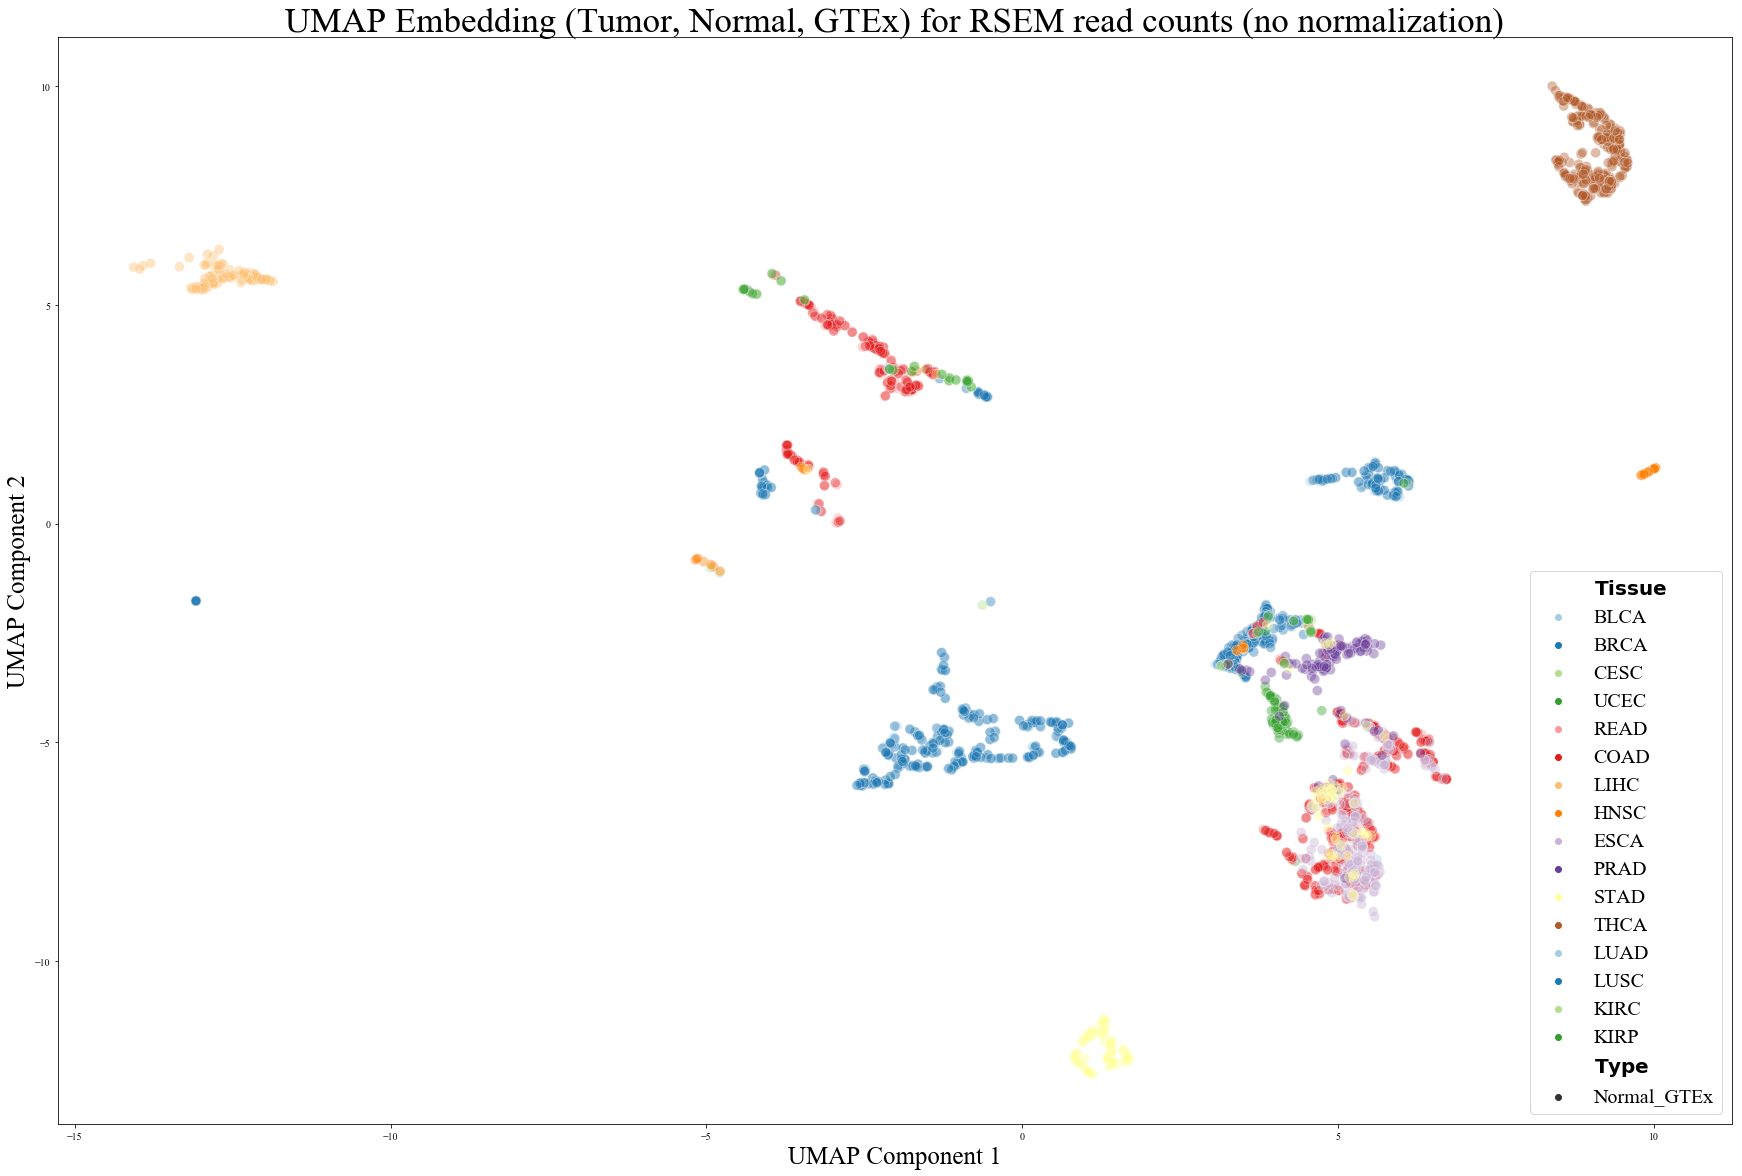

In [14]:
emb_df = pd.DataFrame(emb, index=pca_input.index, columns=['PC1', 'PC2'])
emb_df['Type'] = pca_input.Type
emb_df['Tissue'] = pca_input.Tissue

fig = plt.figure(figsize=(30, 20))
g = sns.scatterplot(data=emb_df[emb_df.Type == 'Normal_GTEx'], x='PC1', y='PC2', hue='Tissue', style='Type',
                    alpha=0.4, palette=sns.color_palette("Paired", n_colors=emb_df.Tissue.nunique()), s=100)
g.set_xlabel('UMAP Component 1', fontsize=25)
g.set_ylabel('UMAP Component 2', fontsize=25)
legend = plt.legend(fontsize=20)
legend.texts[0].set_text(r"$\bf{Tissue}$")
legend.texts[17].set_text(r"$\bf{Type}$")
g.set_title('UMAP Embedding (Tumor, Normal, GTEx) for RSEM read counts (no normalization)', fontsize=35)
#fig.savefig('../../data/pancancer/TCGA/expression/UMAP_embedding_raw.png', dpi=150)

## Step 5: Expression of cancer genes vs. other genes

In [34]:

onco_tsgs = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t')
onco_tsgs.set_index('Gene Symbol', inplace=True)

cgc = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv')

all_foldchanges['Gene_Type'] = 'Other'
all_foldchanges.loc[all_foldchanges.index.isin(onco_tsgs[onco_tsgs['Classification*'] == 'TSG'].index), 'Gene_Type'] = 'TSG'
all_foldchanges.loc[all_foldchanges.index.isin(onco_tsgs[onco_tsgs['Classification*'] == 'Oncogene'].index), 'Gene_Type'] = 'Oncogene'
all_foldchanges.loc[all_foldchanges.index.isin(cgc['Gene Symbol']), 'Gene_Type'] = 'CGC'
all_foldchanges.head()

blca      brca      cesc      ucec      read      coad      lihc  \
A1BG    -0.122802  1.097760 -2.284813 -1.125705 -1.332400 -1.479515 -1.770056   
A1CF     0.000000  0.000000  0.000000  0.000000  0.047850 -1.068919 -0.676472   
A2M     -2.675546 -1.525315 -3.444464 -2.250498 -1.335999 -1.420633 -1.416134   
A2ML1    2.636416 -0.999089  5.286600  0.918906  0.659925  0.650765  0.000000   
A3GALT2  0.000000  0.000000  0.137504  0.000000  0.000000  0.000000  0.000000   

             hnsc      esca      prad      stad      thca      luad      lusc  \
A1BG     0.900462  0.312615 -1.746961 -0.948815  0.967666  0.096528  0.076179   
A1CF     0.000000 -3.826548  0.000000  1.256539  0.000000  0.000000  0.000000   
A2M      0.098292 -0.690401  0.269743 -0.035234  0.479702 -2.300168 -3.960427   
A2ML1   -2.916785  3.695813 -0.797013 -1.114216 -1.913463  0.226389  5.638954   
A3GALT2  0.000000 -0.168123  0.000000 -1.415037  0.000000  0.000000  0.000000   

             kirc      kirp Gene_Type  
A1BG     0.370421 -0.050118     Other  
A1CF     0.304846 -3.802608       CGC  
A2M      0.369869 -1.035350     Other  
A2ML1   -2.796747 -1.949727     Other  
A3GALT2  0.000000  0.000000     Other

(-5, 5)

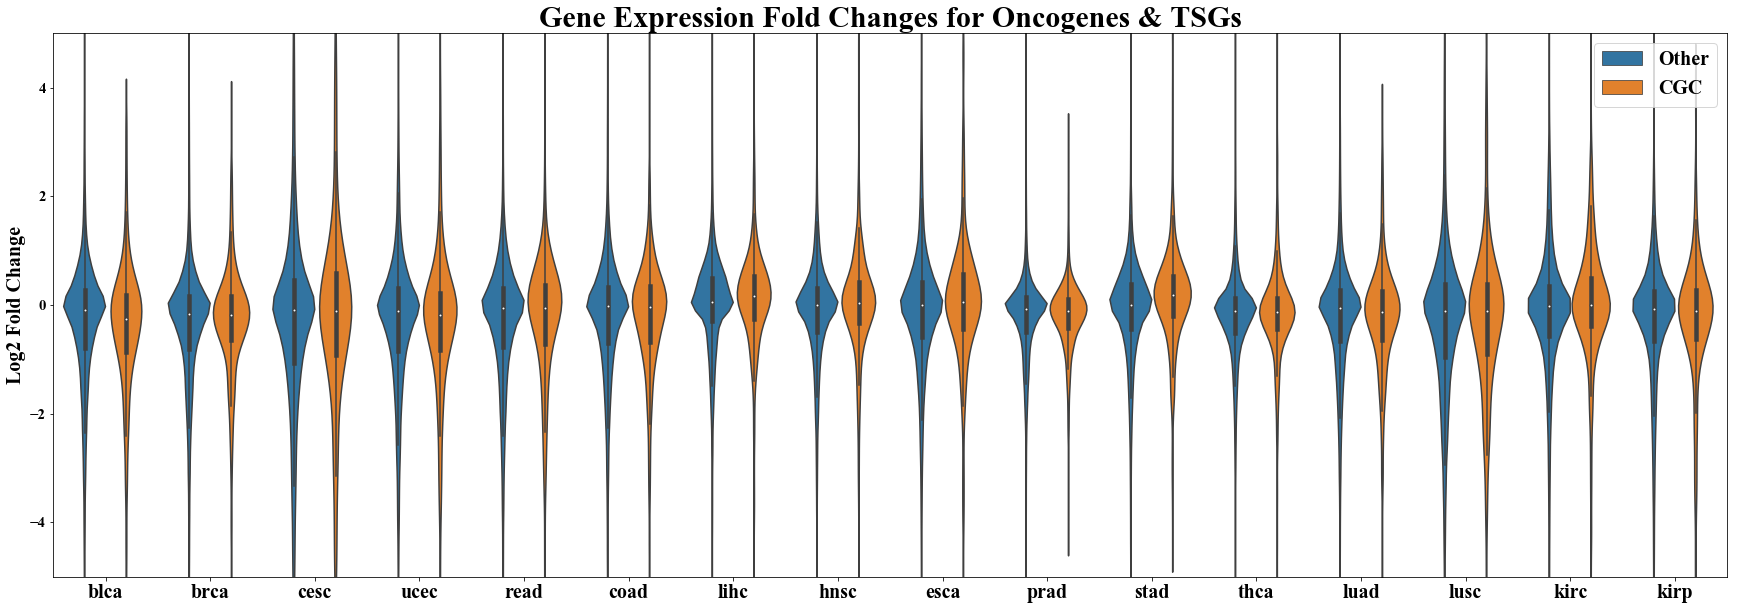

In [37]:

onco_tsgs = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t')
onco_tsgs.set_index('Gene Symbol', inplace=True)

cgc = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv')

all_foldchanges['Gene_Type'] = 'Other'
#all_foldchanges.loc[all_foldchanges.index.isin(onco_tsgs[onco_tsgs['Classification*'] == 'TSG'].index), 'Gene_Type'] = 'TSG'
#all_foldchanges.loc[all_foldchanges.index.isin(onco_tsgs[onco_tsgs['Classification*'] == 'Oncogene'].index), 'Gene_Type'] = 'Oncogene'
all_foldchanges.loc[all_foldchanges.index.isin(cgc['Gene Symbol']), 'Gene_Type'] = 'CGC'


fig = plt.figure(figsize=(30, 10))
ax = sns.violinplot(data=pd.melt(all_foldchanges, id_vars='Gene_Type'), x='variable', y='value', hue='Gene_Type')

plt.xlabel('')
plt.ylabel('Log2 Fold Change', fontsize=20)
plt.title('Gene Expression Fold Changes for Oncogenes & TSGs', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.legend(loc='upper right', fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.ylim([-5, 5])

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log2
/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log2
/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log2


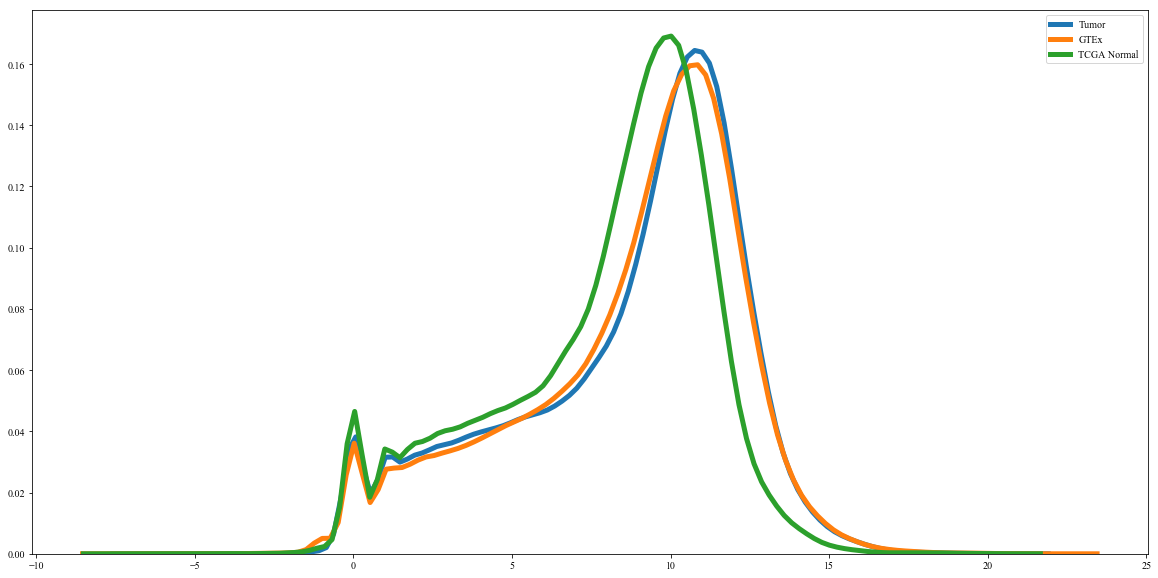

In [95]:
fig = plt.figure(figsize=(20, 10))
bins = np.linspace(-10, 1000, 100)

sns.distplot(np.log2(pd.DataFrame([i.median(axis=1) for i in tumor_fpkm], index=[i[1] for i in tissue_pairs]).T.dropna().values.flatten()),
             hist=False, bins=bins, label='Tumor', kde_kws={"lw": 5})
sns.distplot(np.log2(pd.DataFrame([i.median(axis=1) for i in tcga_normal_fpkm], index=[i[1] for i in tissue_pairs]).T.dropna().values.flatten()),
             hist=False, bins=bins, label='GTEx', kde_kws={"lw": 5})
sns.distplot(np.log2(pd.DataFrame([i.median(axis=1) for i in gtex_fpkm], index=[i[1] for i in tissue_pairs]).T.dropna().values.flatten()),
             hist=False, bins=bins, label='TCGA Normal', kde_kws={"lw": 5})
#plt.xlim([0, 200000])

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(-10, 10)

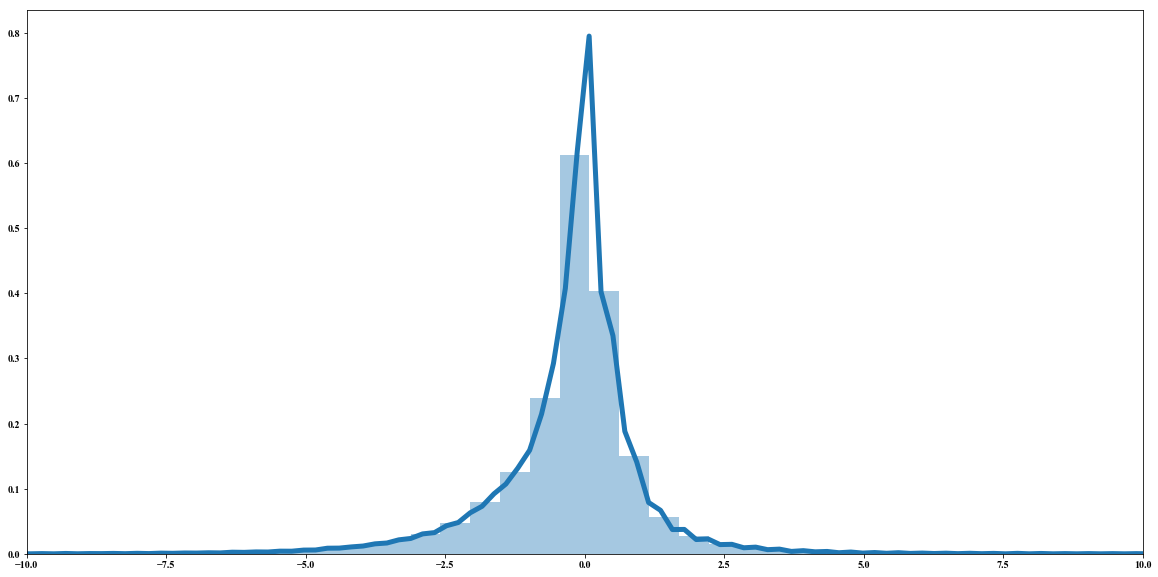

In [17]:
fig = plt.figure(figsize=(20, 10))
sns.distplot(all_foldchanges.drop('Gene_Type', axis=1).values.flatten(), hist=True, label='Log2 Fold Change', kde_kws={"lw": 5})
plt.xlim([-10, 10])

In [96]:
all_foldchanges.lusc.sort_values(ascending=False).head(30)

CALML3       9.658651
DSG3         9.325512
KRT6A        8.987039
KRT6B        8.624246
PRAME        8.217785
AKR1B10      8.174180
KRT6C        8.141324
DLX6         8.016808
KRT5         8.014400
KRT16        7.853927
GJB6         7.852317
HOXC13       7.643856
CERS3        7.620586
SERPINB13    7.617384
FOXE1        7.577429
HOXD13       7.523562
MAGEA4       7.497187
MAGEA9       7.459432
FAM83C       7.447083
SERPINB5     7.441284
SPRR1B       7.420947
ZIC5         7.409391
HOXD11       7.385258
SPRR3        7.353777
UGT1A7       7.344917
A2ML1        7.330917
RAET1L       7.268244
MAGEA9B      7.247643
UGT1A10      7.154919
KRT14        6.943393
Name: lusc, dtype: float64

## Step 6: Write mean foldchanges and raw expression data to disk
As a result from this notebook, I write the $Gene \times Ctype$ matrix containing fold changes in gene expression between tumor and gtex normal.

In [97]:
# replace NaNs with 0
no_of_nan_elems = all_foldchanges.isnull().sum().sum()
all_foldchanges.replace(np.nan, 0, inplace=True)
print ("Replaced {} NaN values in gene expression with 0 (out of {})".format(no_of_nan_elems, np.prod(all_foldchanges.shape)))

# drop gene type column
all_foldchanges.drop('Gene_Type', axis=1, errors='ignore', inplace=True)

# write to file
all_foldchanges.to_csv('../../data/pancancer/TCGA/expression/expression_mean_counts.tsv', sep='\t')

Replaced 0 NaN values in gene expression with 0 (out of 300272)


In [98]:
all_foldchanges.head()

blca      brca      cesc      ucec      read      coad      lihc  \
A1BG     0.226633  1.184298 -2.206794 -0.857162 -1.207777 -1.338266 -1.185094   
A1CF    -1.000000 -1.584963  0.000000 -1.000000 -0.668056 -1.295782 -0.462547   
A2M     -2.414270 -1.316157 -3.960867 -1.926294 -0.990964 -1.457258 -0.895757   
A2ML1    2.971180 -1.115477  6.266787  1.450661 -1.000000  0.000000  0.000000   
A3GALT2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             hnsc      esca      prad      stad      thca      luad      lusc  \
A1BG     1.144881  0.840186 -1.732335 -0.514533  0.914754  0.619915 -0.200561   
A1CF     0.000000 -2.678072  0.000000  2.718366  0.000000 -1.000000  0.000000   
A2M      0.273526  0.243404 -0.125804  0.578988  0.290783 -1.764107 -4.243002   
A2ML1   -2.782339  4.123382 -1.119299 -0.485427 -3.000000  0.415037  7.330917   
A3GALT2  0.000000  0.000000  0.000000 -0.415037  0.000000  0.000000  0.000000   

             kirc      kirp  
A1BG     0.382328 -0.081843  
A1CF     0.271087 -4.192567  
A2M      0.250109 -1.669579  
A2ML1   -1.000000 -2.000000  
A3GALT2  0.000000  0.000000

## Step 4: T-SNE plot of features